<a href="https://colab.research.google.com/github/keetrak17/keetrak_leranbay_project/blob/main/Logistic_DT_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
##### Importing Relevant Libraries ######
#########################################

import pandas as pd
import numpy as np
import os
import seaborn as sns
import pickle ### helps storing data in pickle files

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, plot_roc_curve, confusion_matrix,f1_score ## model evaluation metrics
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler ## (x-mean(variable))/standard_deviation(variable)
from sklearn.model_selection import StratifiedShuffleSplit ### datasplitting
 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV          ### hyperparameter finding

from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor          ### helps fitting a decision tree
from sklearn.ensemble import RandomForestClassifier       ### models from sklearn

In [2]:
%matplotlib inline

In [23]:
####### Loading Data ######
###########################

# cwd = os.getcwd() ##gets current working directory

# data_path = str(cwd) + '/Existing_Base.csv'

data = pd.read_csv('/Existing_Base.csv')  ## Loads the data

# Data Exploration

In [28]:
data.shape ## gets the shape of the data

(10155, 32)

In [29]:
data.head()

,REF_NO,children,age_band,status,occupation,occupation_partner,home_status,family_income,self_employed,self_employed_partner,year_last_moved,TVarea,post_code,post_area,Average Credit Card Transaction,Balance Transfer,Term Deposit,Life Insurance,Medical Insurance,Average A/C Balance,Personal Loan,Investment in Mutual Fund,Investment Tax Saving Bond,Home Loan,Online Purchase Amount,Revenue Grid,gender,region,Investment in Commudity,Investment in Equity,Investment in Derivative,Portfolio Balance
0,1,Zero,51-55,Partner,Manual Worker,Secretarial/Admin,Own Home,"<17,500, >=15,000",No,No,1972,HTV,NP4 9HS,NP4,148.44,142.95,0.00,81.96,0.00,29.99,0.00,61.95,19.99,0.00,0.00,1,Female,Wales,74.67,18.66,32.32,89.43
1,2,Zero,55-60,Single/Never Married,Retired,Retired,Own Home,"<27,500, >=25,000",No,No,1998,Granada,M41 0QH,M41,0.00,74.98,0.00,25.99,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2,Female,North West,20.19,0.00,4.33,22.78
2,3,Zero,26-30,Single/Never Married,Professional,Other,Own Home,"<30,000, >=27,500",Yes,No,1996,Tyne Tees,NE30 1JZ,NE30,0.00,166.44,20.99,291.37,11.48,166.94,0.00,15.99,0.00,3.49,0.00,2,Male,North,98.06,31.07,80.96,171.78
3,5,Zero,18-21,Single/Never Married,Professional,Manual Worker,Own Home,"<15,000, >=12,500",No,No,1997,Central,HR9 7RJ,HR9,0.00,0.00,0.00,20.49,0.00,39.46,0.00,45.44,0.00,0.00,0.00,2,Female,West Midlands,4.10,14.15,17.57,-41.70
4,6,Zero,45-50,Partner,Business Manager,Unknown,Own Home,"<30,000, >=27,500",No,No,1995,Scottish TV,KA10 7LS,KA10,73.45,57.96,0.00,177.42,41.95,39.47,10.97,212.84,0.00,45.91,25.98,2,Female,Scotland,70.16,55.86,80.44,235.02


In [30]:
#### Distribution of target class ####

data['Revenue Grid'].value_counts()

#### There is class imbalance in my dataset. We might ask for more observations for class 1.

#### if the distribution is 80%-20% - generally not a major concern.
#### if the distribution is between 80%-20% and 95%-5% -  area of slight concern..
#### if the distribution is less than 95-5% - we should get concerned - expect that your model might be a bad model

2    9069
1    1086
Name: Revenue Grid, dtype: int64

In [31]:
data.info() ### prints out informatio regarding columns in the data

#### Insight #####
####################

# Out of 32 columns, we have around 18 columns of numeric type, 14 columns of string type
# There doesn't seem to have missing values in the columns, however we would investigate this once again

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10155 entries, 0 to 10154
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   REF_NO                           10155 non-null  int64  
 1   children                         10155 non-null  object 
 2   age_band                         10155 non-null  object 
 3   status                           10155 non-null  object 
 4   occupation                       10155 non-null  object 
 5   occupation_partner               10155 non-null  object 
 6   home_status                      10155 non-null  object 
 7   family_income                    10155 non-null  object 
 8   self_employed                    10155 non-null  object 
 9   self_employed_partner            10155 non-null  object 
 10  year_last_moved                  10155 non-null  int64  
 11  TVarea                           10155 non-null  object 
 12  post_code         

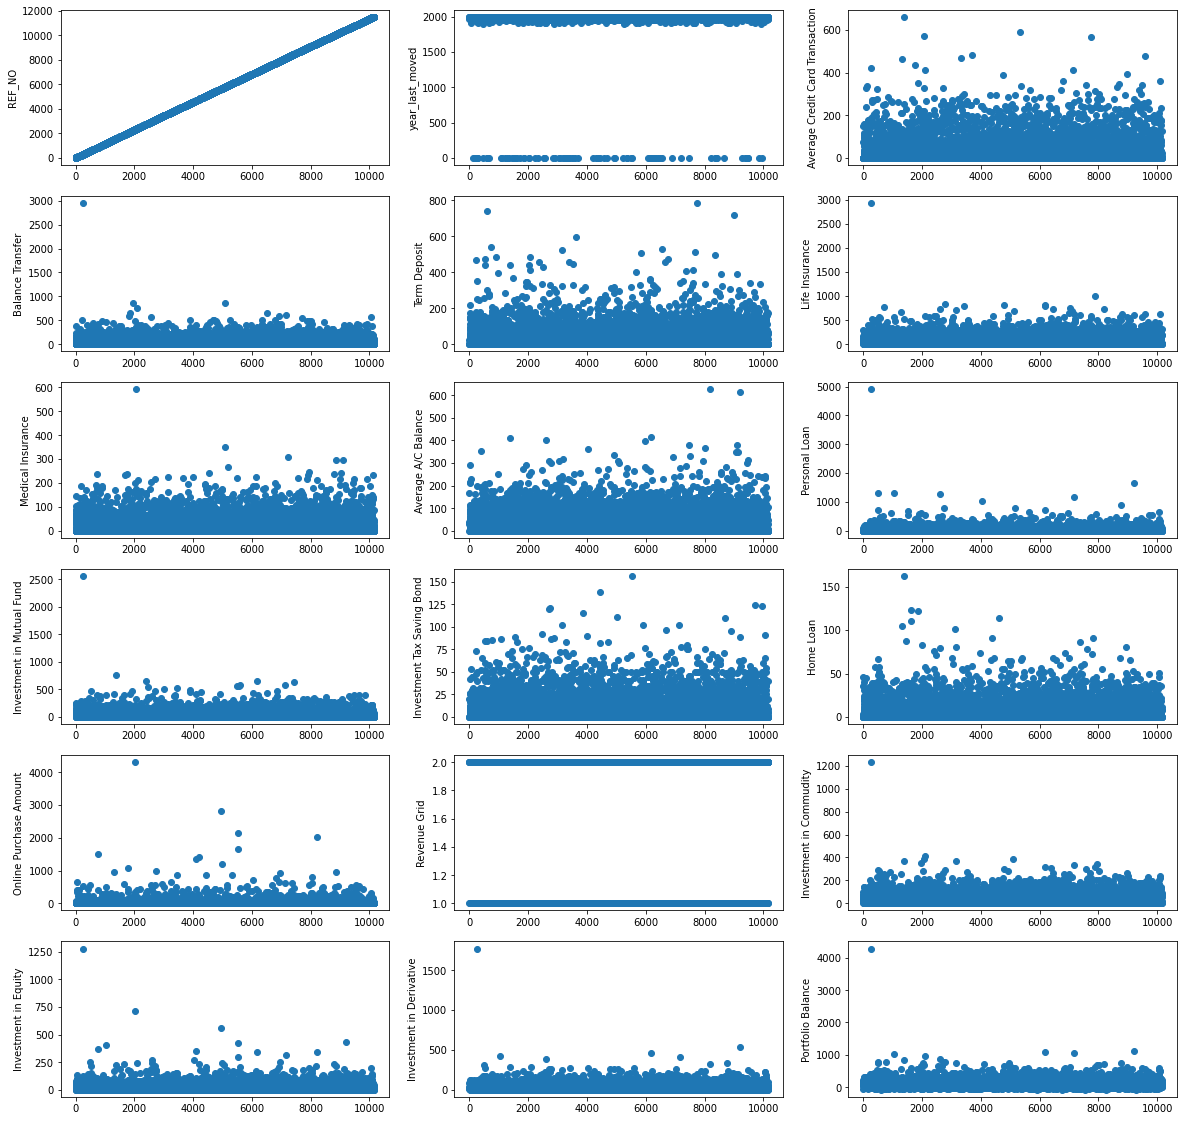

In [32]:
#### Visualizing numeric columns ######

numeric_cols = data.select_dtypes(include = np.number) ### selects numeric columns

column_names = list(numeric_cols.columns)

col_index = 0

plot_rows = 6
plot_cols = 3

fig, ax = plt.subplots(nrows = plot_rows,ncols=plot_cols,figsize = (20,20))

for row_count in range(plot_rows):
    for col_count in range(plot_cols):
        ax[row_count][col_count].scatter(y = numeric_cols[column_names[col_index]],x=numeric_cols.index)
        ax[row_count][col_count].set_ylabel(column_names[col_index])
        col_index = col_index + 1
        
###### Insights #####
#####################

## Ref Number column just contains the index so can be removed.
## year_last_moved column seem to have many values close to 0 or 0, these seem to be missing values, investigate them.
## Average_credit_card_transaction,Balance Transfer seems to be highly right skewed, check if the skewness could be reduced.
## A single customer with very high value of balance transfer/life insurance etc stands out, this row could be considered outlier and be removed, #row number 250
## Capping could be done to limit the impact of outliers.
## Normalization could be done since the scale is different for most of the variables.

In [37]:
data['Average Credit Card Transaction'].mean()

23.441756770064128

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


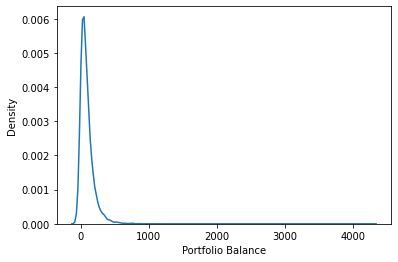

In [40]:
sns.distplot(data['Portfolio Balance'],hist = False)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


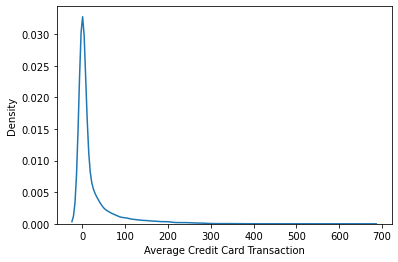

In [42]:
sns.distplot(data['Average Credit Card Transaction'],hist =False)

In [46]:
data.loc[data['Life Insurance']>2500,:]

,REF_NO,children,age_band,status,occupation,occupation_partner,home_status,family_income,self_employed,self_employed_partner,year_last_moved,TVarea,post_code,post_area,Average Credit Card Transaction,Balance Transfer,Term Deposit,Life Insurance,Medical Insurance,Average A/C Balance,Personal Loan,Investment in Mutual Fund,Investment Tax Saving Bond,Home Loan,Online Purchase Amount,Revenue Grid,gender,region,Investment in Commudity,Investment in Equity,Investment in Derivative,Portfolio Balance
250,279,1,41-45,Partner,Professional,Professional,Own Home,">=35,000",No,No,1988,Tyne Tees,NE38 8SF,NE38,0.0,2951.76,251.33,2930.41,21.96,197.9,4905.93,2561.27,9.48,0.0,0.0,2,Male,North,1231.09,1279.1,1771.16,4283.56


In [47]:
##### Describing categorical columns #####

cat_data = data.select_dtypes(include = np.object)

column_names = list(cat_data.columns)

for column in column_names:
    print('Column ', column)
    print('Number of unique elements ', cat_data[column].nunique())
    print('***************\n')
    
##### Insights ######
#####################

## post_code has too many unique values, converting them into onehot encoded vectors would blow up the dimensions. Currently we will remove the column and go ahead with the model
## Similarly for post area

Column  children
Number of unique elements  5
***************

Column  age_band
Number of unique elements  13
***************

Column  status
Number of unique elements  5
***************

Column  occupation
Number of unique elements  9
***************

Column  occupation_partner
Number of unique elements  9
***************

Column  home_status
Number of unique elements  5
***************

Column  family_income
Number of unique elements  13
***************

Column  self_employed
Number of unique elements  2
***************

Column  self_employed_partner
Number of unique elements  2
***************

Column  TVarea
Number of unique elements  14
***************

Column  post_code
Number of unique elements  10040
***************

Column  post_area
Number of unique elements  2039
***************

Column  gender
Number of unique elements  3
***************

Column  region
Number of unique elements  13
***************



# Data Preprocessing

In [48]:
print('The shape of the data before preprocessing ', data.shape)

The shape of the data before preprocessing  (10155, 32)


In [49]:
remove_cols = []

In [55]:
#### Preprocess - 1: Remove the post_code, post_area and Ref_no column ####

data.drop(['REF_NO'],axis=1,inplace=True)  ## removes specified columns

### Preprocess -2 :  Identify and remove the outlier row #######

data.loc[data['Life Insurance']>2500,:]

data = data.loc[(data['Life Insurance']<2500),:]

remove_cols.append('REF_NO')

KeyError: ignored

In [53]:
print('The shape of the data after first preprocessing block ', data.shape)

data.reset_index(drop=True,inplace=True) ### resetting index
#   https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reset_index.html

The shape of the data after first preprocessing block  (10154, 31)


In [58]:
##### Preprocess - 3: Analyze the year_last_moved column ######

print(data['year_last_moved'].describe())

print(np.sum(data['year_last_moved']==0))

##### Insight #####
###################

# Although there aren't many 0's, the column seems to be a bit irrelevant in predicting customers with high transaction potential.
# Hence this coulumn would also be dropped

data.drop(['year_last_moved'],axis=1,inplace=True)

remove_cols.append('year_last_moved')

count    10154.000000
mean      1968.374434
std        180.211011
min          0.000000
25%       1978.000000
50%       1988.000000
75%       1994.000000
max       1999.000000
Name: year_last_moved, dtype: float64
84


In [59]:
print(data.shape)

(10154, 30)


In [67]:
###### Preprocess -4 : Capping the numeric columns to 97th percentile #####

numeric_cols = data.select_dtypes(include = np.number) ### find the numeric columns
column_names = list(numeric_cols.columns) ### contains the numeric column names
column_names.remove('Revenue Grid')  ### removing revenue grid
percentile_dict = {}

for column in column_names:  ### iterating over all numeric columns
    percentile_97_val = np.quantile(data[column],0.97)  ### finding the 97th percentile value
    data.loc[data[column]>percentile_97_val,column] = percentile_97_val  ## replace all the values greater than 97th percentile with the 97th percentile value
    percentile_dict.update({column : percentile_97_val})
  
with open('capping_percentiles.pickle','wb') as f:
    pickle.dump(percentile_dict,f)


In [72]:
with open('capping_percentiles.pickle','rb') as f:
  a = pickle.load(f)
  print(a)

{'Average Credit Card Transaction': 169.97, 'Balance Transfer': 229.13269999999994, 'Term Deposit': 159.4241, 'Life Insurance': 296.39279999999997, 'Medical Insurance': 102.9164, 'Average A/C Balance': 143.39, 'Personal Loan': 185.3441, 'Investment in Mutual Fund': 183.57139999999993, 'Investment Tax Saving Bond': 40.57249999999996, 'Home Loan': 31.43, 'Online Purchase Amount': 141.6497, 'Investment in Commudity': 137.6241, 'Investment in Equity': 86.90279999999998, 'Investment in Derivative': 116.51410000000001, 'Portfolio Balance': 329.0451}


In [73]:
data[column_names].describe()

,Average Credit Card Transaction,Balance Transfer,Term Deposit,Life Insurance,Medical Insurance,Average A/C Balance,Personal Loan,Investment in Mutual Fund,Investment Tax Saving Bond,Home Loan,Online Purchase Amount,Investment in Commudity,Investment in Equity,Investment in Derivative,Portfolio Balance
count,10154.000000,10154.000000,10154.000000,10154.000000,10154.000000,10154.000000,10154.000000,10154.000000,10154.000000,10154.000000,10154.000000,10154.000000,10154.000000,10154.000000,10154.000000
mean,21.444166,43.347380,24.952700,62.604343,17.850445,30.365812,21.515394,39.640963,5.618865,4.074453,13.042740,35.017772,20.117256,30.437694,86.489283
std,41.399771,61.291584,41.040021,77.304680,26.698522,38.215538,43.584435,47.904665,10.631669,7.969996,31.336163,34.854488,21.310442,28.973184,84.286912
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-78.430000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.215000,4.670000,8.740000,26.602500
50%,0.000000,17.960000,0.000000,31.980000,0.510000,14.990000,0.000000,23.480000,0.000000,0.000000,0.000000,23.940000,12.980000,21.335000,66.175000
75%,23.980000,65.240000,34.987500,94.380000,27.470000,46.477500,21.480000,59.480000,5.970000,4.490000,7.980000,50.787500,28.300000,42.980000,125.917500
max,169.970000,229.132700,159.424100,296.392800,102.916400,143.390000,185.344100,183.571400,40.572500,31.430000,141.649700,137.624100,86.902800,116.514100,329.045100


In [74]:
####### Preprocess-5 : Scaling the columns ######

scaler = StandardScaler()  ### instance of this object
# class sklearn.preprocessing.StandardScaler(*, copy=True, with_mean=True, with_std=True)
# The standard score of a sample x is calculated as:
# z = (x - u) / s
# where u is the mean of the training samples or zero if with_mean=False, and s is the standard deviation of the training samples or one if with_std=False.

scaler.fit(data[column_names]) ### it will compute mean and standard deviation of every column

data[column_names] = scaler.transform(data[column_names]) #### apply the formula (x-mean)/s.d

with open('scaler.pickle','wb') as f:
  pickle.dump(scaler,f)

In [75]:
data.head()

,children,age_band,status,occupation,occupation_partner,home_status,family_income,self_employed,self_employed_partner,TVarea,post_code,post_area,Average Credit Card Transaction,Balance Transfer,Term Deposit,Life Insurance,Medical Insurance,Average A/C Balance,Personal Loan,Investment in Mutual Fund,Investment Tax Saving Bond,Home Loan,Online Purchase Amount,Revenue Grid,gender,region,Investment in Commudity,Investment in Equity,Investment in Derivative,Portfolio Balance
0,Zero,51-55,Partner,Manual Worker,Secretarial/Admin,Own Home,"<17,500, >=15,000",No,No,HTV,NP4 9HS,NP4,3.067700,1.625142,-0.608039,0.250394,-0.668626,-0.009834,-0.493673,0.465719,1.351796,-0.511249,-0.416241,1,Female,Wales,1.137707,-0.068386,0.064970,0.034891
1,Zero,55-60,Single/Never Married,Retired,Retired,Own Home,"<27,500, >=25,000",No,No,Granada,M41 0QH,M41,-0.518003,0.516126,-0.608039,-0.473660,-0.668626,-0.794632,-0.493673,-0.827538,-0.528529,-0.511249,-0.416241,2,Female,North West,-0.425440,-0.944056,-0.901143,-0.755899
2,Zero,26-30,Single/Never Married,Professional,Other,Own Home,"<30,000, >=27,500",Yes,No,Tyne Tees,NE30 1JZ,NE30,-0.518003,2.008411,-0.096562,2.959419,-0.238618,2.957691,-0.493673,-0.493733,-0.528529,-0.073335,-0.416241,2,Male,North,1.808815,0.513987,1.743847,1.011959
3,Zero,18-21,Single/Never Married,Professional,Manual Worker,Own Home,"<15,000, >=12,500",No,No,Central,HR9 7RJ,HR9,-0.518003,-0.707267,-0.608039,-0.544811,-0.668626,0.237983,-0.493673,0.121060,-0.528529,-0.511249,-0.416241,2,Female,West Midlands,-0.887097,-0.280029,-0.444146,-1.520943
4,Zero,45-50,Partner,Business Manager,Unknown,Own Home,"<30,000, >=27,500",No,No,Scottish TV,KA10 7LS,KA10,1.256248,0.238423,-0.608039,1.485309,0.902699,0.238244,-0.241965,3.004666,-0.528529,3.432485,0.412874,2,Female,Scotland,1.008305,1.677323,1.725898,1.762291


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


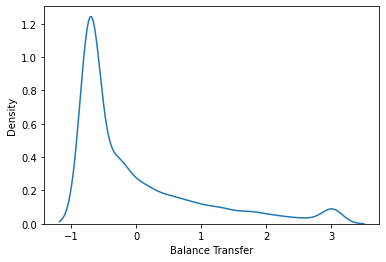

In [76]:
sns.distplot(data['Balance Transfer'],hist = False)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


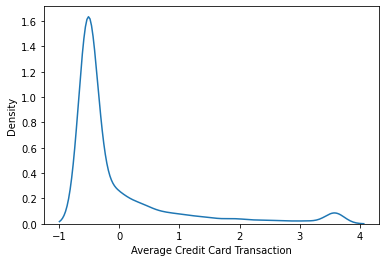

In [77]:
sns.distplot(data['Average Credit Card Transaction'],hist = False)

In [78]:
data.dtypes

children                            object
age_band                            object
status                              object
occupation                          object
occupation_partner                  object
home_status                         object
family_income                       object
self_employed                       object
self_employed_partner               object
TVarea                              object
post_code                           object
post_area                           object
Average Credit Card Transaction    float64
Balance Transfer                   float64
Term Deposit                       float64
Life Insurance                     float64
Medical Insurance                  float64
Average A/C Balance                float64
Personal Loan                      float64
Investment in Mutual Fund          float64
Investment Tax Saving Bond         float64
Home Loan                          float64
Online Purchase Amount             float64
Revenue Gri

In [93]:
##### Preprocessing categorical columns ######

### Analzing the children column ####

print(data['children'].value_counts())

children_pickle = {}
#### Insight ###
################

#Since the occurances of 4+ children is quite low when compared to rest, we can replace them with 3
#Create one hot encoded vectors for the same

data.loc[data['children']== '4+','children'] = '3'

children_data = pd.get_dummies(data['children'],prefix ='chidren')

data.drop(['children'],axis=1,inplace=True)

data = pd.concat([data,children_data],axis=1)

children_pickle.update({'merge_values':{'4+': '3'},
                        'new_cols' : ['1','2','3','Zero'],
                        'prefix' : 'children'})

KeyError: ignored

In [94]:
data.head()

,age_band,status,occupation,occupation_partner,home_status,family_income,self_employed,self_employed_partner,TVarea,post_code,post_area,Average Credit Card Transaction,Balance Transfer,Term Deposit,Life Insurance,Medical Insurance,Average A/C Balance,Personal Loan,Investment in Mutual Fund,Investment Tax Saving Bond,Home Loan,Online Purchase Amount,Revenue Grid,gender,region,Investment in Commudity,Investment in Equity,Investment in Derivative,Portfolio Balance,chidren_1,chidren_2,chidren_3,chidren_Zero
0,51-55,Partner,Manual Worker,Secretarial/Admin,Own Home,"<17,500, >=15,000",No,No,HTV,NP4 9HS,NP4,3.067700,1.625142,-0.608039,0.250394,-0.668626,-0.009834,-0.493673,0.465719,1.351796,-0.511249,-0.416241,1,Female,Wales,1.137707,-0.068386,0.064970,0.034891,0,0,0,1
1,55-60,Single/Never Married,Retired,Retired,Own Home,"<27,500, >=25,000",No,No,Granada,M41 0QH,M41,-0.518003,0.516126,-0.608039,-0.473660,-0.668626,-0.794632,-0.493673,-0.827538,-0.528529,-0.511249,-0.416241,2,Female,North West,-0.425440,-0.944056,-0.901143,-0.755899,0,0,0,1
2,26-30,Single/Never Married,Professional,Other,Own Home,"<30,000, >=27,500",Yes,No,Tyne Tees,NE30 1JZ,NE30,-0.518003,2.008411,-0.096562,2.959419,-0.238618,2.957691,-0.493673,-0.493733,-0.528529,-0.073335,-0.416241,2,Male,North,1.808815,0.513987,1.743847,1.011959,0,0,0,1
3,18-21,Single/Never Married,Professional,Manual Worker,Own Home,"<15,000, >=12,500",No,No,Central,HR9 7RJ,HR9,-0.518003,-0.707267,-0.608039,-0.544811,-0.668626,0.237983,-0.493673,0.121060,-0.528529,-0.511249,-0.416241,2,Female,West Midlands,-0.887097,-0.280029,-0.444146,-1.520943,0,0,0,1
4,45-50,Partner,Business Manager,Unknown,Own Home,"<30,000, >=27,500",No,No,Scottish TV,KA10 7LS,KA10,1.256248,0.238423,-0.608039,1.485309,0.902699,0.238244,-0.241965,3.004666,-0.528529,3.432485,0.412874,2,Female,Scotland,1.008305,1.677323,1.725898,1.762291,0,0,0,1


In [101]:
from sklearn.preprocessing import OneHotEncoder

age_band_encoder = OneHotEncoder()

age_band_encoder.fit(data[['age_band']])

dummy_cols = age_band_encoder.transform(data[['age_band']])

with open('age_band_encoder.pickle','wb') as f:
  pickle.dump(age_band_encoder,f)

In [102]:
dummy_cols

<10154x13 sparse matrix of type '<class 'numpy.float64'>'
	with 10154 stored elements in Compressed Sparse Row format>

In [98]:
data.head()

,age_band,status,occupation,occupation_partner,home_status,family_income,self_employed,self_employed_partner,TVarea,post_code,post_area,Average Credit Card Transaction,Balance Transfer,Term Deposit,Life Insurance,Medical Insurance,Average A/C Balance,Personal Loan,Investment in Mutual Fund,Investment Tax Saving Bond,Home Loan,Online Purchase Amount,Revenue Grid,gender,region,Investment in Commudity,Investment in Equity,Investment in Derivative,Portfolio Balance,chidren_1,chidren_2,chidren_3,chidren_Zero
0,51-55,Partner,Manual Worker,Secretarial/Admin,Own Home,"<17,500, >=15,000",No,No,HTV,NP4 9HS,NP4,3.067700,1.625142,-0.608039,0.250394,-0.668626,-0.009834,-0.493673,0.465719,1.351796,-0.511249,-0.416241,1,Female,Wales,1.137707,-0.068386,0.064970,0.034891,0,0,0,1
1,55-60,Single/Never Married,Retired,Retired,Own Home,"<27,500, >=25,000",No,No,Granada,M41 0QH,M41,-0.518003,0.516126,-0.608039,-0.473660,-0.668626,-0.794632,-0.493673,-0.827538,-0.528529,-0.511249,-0.416241,2,Female,North West,-0.425440,-0.944056,-0.901143,-0.755899,0,0,0,1
2,26-30,Single/Never Married,Professional,Other,Own Home,"<30,000, >=27,500",Yes,No,Tyne Tees,NE30 1JZ,NE30,-0.518003,2.008411,-0.096562,2.959419,-0.238618,2.957691,-0.493673,-0.493733,-0.528529,-0.073335,-0.416241,2,Male,North,1.808815,0.513987,1.743847,1.011959,0,0,0,1
3,18-21,Single/Never Married,Professional,Manual Worker,Own Home,"<15,000, >=12,500",No,No,Central,HR9 7RJ,HR9,-0.518003,-0.707267,-0.608039,-0.544811,-0.668626,0.237983,-0.493673,0.121060,-0.528529,-0.511249,-0.416241,2,Female,West Midlands,-0.887097,-0.280029,-0.444146,-1.520943,0,0,0,1
4,45-50,Partner,Business Manager,Unknown,Own Home,"<30,000, >=27,500",No,No,Scottish TV,KA10 7LS,KA10,1.256248,0.238423,-0.608039,1.485309,0.902699,0.238244,-0.241965,3.004666,-0.528529,3.432485,0.412874,2,Female,Scotland,1.008305,1.677323,1.725898,1.762291,0,0,0,1


In [103]:
#### Analyzing age_band column ###

print(data['age_band'].value_counts())

#### Insight ####
#################

#Lets add unknown to the most prominant class of 45-50
#The mean age of the band could be taken and this column could be converted into a numeric column, however it so can
#happen that the band actually matters rather than the actual age, hence we create dummies 

data.loc[data['age_band']=='Unknown','age_band'] ='45-50'

age_band_dummies = pd.get_dummies(data['age_band'],prefix = 'age_band')

data.drop(['age_band'],axis=1,inplace=True)

data = pd.concat([data,age_band_dummies],axis=1)

45-50      1359
36-40      1134
41-45      1111
31-35      1061
51-55      1052
55-60      1047
26-30       927
61-65       881
65-70       598
22-25       456
71+         410
18-21        63
Unknown      55
Name: age_band, dtype: int64


In [104]:
#### Analyzing status column ###

print(data['status'].value_counts())

#### Insight ####
#################

#Lets add unknown to the most prominant class of Partner
#Create dummeis for the rest 

data.loc[data['status']=='Unknown','status'] ='Partner'

status_dummies = pd.get_dummies(data['status'],drop_first=True,prefix = 'status')

data.drop(['status'],axis=1,inplace=True)

data = pd.concat([data,status_dummies],axis=1)

Partner                 7708
Single/Never Married    1101
Divorced/Separated       679
Widowed                  618
Unknown                   48
Name: status, dtype: int64


In [107]:
#### Analyzing occupation column ###

print(data['occupation'].value_counts())

occupation_dummies = pd.get_dummies(data['occupation'],drop_first=True,prefix = 'occupation')

data.drop(['occupation'],axis=1,inplace=True)

data = pd.concat([data,occupation_dummies],axis=1)

Professional         2448
Retired              2206
Secretarial/Admin    1797
Housewife            1255
Business Manager      732
Unknown               567
Manual Worker         556
Other                 537
Student                56
Name: occupation, dtype: int64


In [147]:
data.loc[[('occupation_Housewife' == 0) & ('occupation_Manual Worker' == 0) & ('occupation_Other' == 0) & ('occupation_Professional' == 0) & ('occupation_Retired' == 0) & ('occupation_Secretarial/Admin' == 0 ) & ('occupation_Student' == 0) & ('occupation_Unknown' == 0]]

SyntaxError: ignored

In [148]:
data

,Average Credit Card Transaction,Balance Transfer,Term Deposit,Life Insurance,Medical Insurance,Average A/C Balance,Personal Loan,Investment in Mutual Fund,Investment Tax Saving Bond,Home Loan,Online Purchase Amount,Revenue Grid,Investment in Commudity,Investment in Equity,Investment in Derivative,Portfolio Balance,chidren_1,chidren_2,chidren_3,chidren_Zero,age_band_18-21,age_band_22-25,age_band_26-30,age_band_31-35,age_band_36-40,age_band_41-45,age_band_45-50,age_band_51-55,age_band_55-60,age_band_61-65,age_band_65-70,age_band_71+,status_Partner,status_Single/Never Married,status_Widowed,occupation_partner_Housewife,occupation_partner_Manual Worker,occupation_partner_Other,occupation_partner_Professional,occupation_partner_Retired,occupation_partner_Secretarial/Admin,occupation_partner_Student,occupation_partner_Unknown,occupation_Housewife,occupation_Manual Worker,occupation_Other,occupation_Professional,occupation_Retired,occupation_Secretarial/Admin,occupation_Student,occupation_Unknown,home_status_Own Home,home_status_Rented Home,"income_< 8,000, >= 4,000","income_<10,000, >= 8,000","income_<12,500, >=10,000","income_<15,000, >=12,500","income_<17,500, >=15,000","income_<20,000, >=17,500","income_<22,500, >=20,000","income_<25,000, >=22,500","income_<27,500, >=25,000","income_<30,000, >=27,500","income_>=35,000",income_Unknown,self_employed_Yes,self_employed_partner_Yes,gender_Male,gender_Unknown
0,3.067700,1.625142,-0.608039,0.250394,-0.668626,-0.009834,-0.493673,0.465719,1.351796,-0.511249,-0.416241,1,1.137707,-0.068386,0.064970,0.034891,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,-0.518003,0.516126,-0.608039,-0.473660,-0.668626,-0.794632,-0.493673,-0.827538,-0.528529,-0.511249,-0.416241,0,-0.425440,-0.944056,-0.901143,-0.755899,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,-0.518003,2.008411,-0.096562,2.959419,-0.238618,2.957691,-0.493673,-0.493733,-0.528529,-0.073335,-0.416241,0,1.808815,0.513987,1.743847,1.011959,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0
3,-0.518003,-0.707267,-0.608039,-0.544811,-0.668626,0.237983,-0.493673,0.121060,-0.528529,-0.511249,-0.416241,0,-0.887097,-0.280029,-0.444146,-1.520943,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,1.256248,0.238423,-0.608039,1.485309,0.902699,0.238244,-0.241965,3.004666,-0.528529,3.432485,0.412874,0,1.008305,1.677323,1.725898,1.762291,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10149,-0.518003,-0.707267,-0.608039,-0.422173,-0.425529,-0.794632,-0.287396,-0.671178,-0.106185,-0.511249,-0.416241,0,-0.795569,-0.779809,-0.720277,-0.904803,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
10150,-0.518003,1.103022,-0.608039,1.782718,-0.668626,-0.716388,-0.493673,-0.514609,-0.528529,-0.511249,-0.416241,0,0.781924,-0.803273,0.205797,0.191388,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
10151,2.499795,-0.707267,0.719511,-0.809879,2.493503,-0.794632,-0.493673,-0.827538,-0.528529,-0.511249,-0.416241,0,0.509349,-0.944056,-0.564953,-0.122318,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
10152,-0.518003,-0.120208,-0.608039,-0.809879,-0.668626,-0.794632,-0.493673,-0.619197,-0.528529,0.490055,-0.416241,0,-0.798151,-0.803742,-0.993302,-0.969347,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0

In [105]:
#### Analyzing occupation_partner column ###

print(data['occupation_partner'].value_counts())

occupation_partner_dummies = pd.get_dummies(data['occupation_partner'],drop_first=True,prefix = 'occupation_partner')

data.drop(['occupation_partner'],axis=1,inplace=True)

data = pd.concat([data,occupation_partner_dummies],axis=1)

Unknown              2394
Professional         2050
Retired              1936
Manual Worker        1508
Business Manager      737
Secretarial/Admin     662
Housewife             527
Other                 324
Student                16
Name: occupation_partner, dtype: int64


In [108]:
data.shape

(10154, 60)

In [110]:
#### Analyzing home_status column ###

print(data['home_status'].value_counts())

#### Insight ####
#################

#Apart form own home the other types seem to be some/kind of rented property and the occurances of those are quite few compared to own house
#combine all others into a category called rent
#Create dummies for rest

data.loc[~(data['home_status'] == 'Own Home'),'home_status'] ='Rented Home'

home_status_dummies = pd.get_dummies(data['home_status'],prefix = 'home_status')

data.drop(['home_status'],axis=1,inplace=True)

data = pd.concat([data,home_status_dummies],axis=1)

KeyError: ignored

In [111]:
#### Analyzing family_income column ###

print(data['family_income'].value_counts())

#### Insight ####
#################

#The family income could be converted into numeric field by taking the mean of the range. We will explore it in the next set of experiments
#In the current experiment, we create dummies

income_dummies = pd.get_dummies(data['family_income'],drop_first=True,prefix = 'income')

data.drop(['family_income'],axis=1,inplace=True)

data = pd.concat([data,income_dummies],axis=1)

>=35,000             2516
<27,500, >=25,000    1227
<30,000, >=27,500     994
<25,000, >=22,500     833
<20,000, >=17,500     683
<12,500, >=10,000     677
<17,500, >=15,000     634
<15,000, >=12,500     629
<22,500, >=20,000     590
<10,000, >= 8,000     563
< 8,000, >= 4,000     402
< 4,000               278
Unknown               128
Name: family_income, dtype: int64


In [112]:
#### Analyzing the self employed, self employed partner and gender column ####

cols = ['self_employed','self_employed_partner','gender']

for column in cols:
    dummies = pd.get_dummies(data[column],drop_first=True,prefix = column)
    data.drop(column,axis=1,inplace=True)
    data = pd.concat([data,dummies],axis=1)

In [113]:
data.shape

(10154, 73)

In [114]:
data.select_dtypes(np.object)

,TVarea,post_code,post_area,region
0,HTV,NP4 9HS,NP4,Wales
1,Granada,M41 0QH,M41,North West
2,Tyne Tees,NE30 1JZ,NE30,North
3,Central,HR9 7RJ,HR9,West Midlands
4,Scottish TV,KA10 7LS,KA10,Scotland
...,...,...,...,...
10149,Carlton,SM4 5RF,SM4,South East
10150,Meridian,RG14 7PA,RG14,South East
10151,Central,OX15 0PU,OX15,South East
10152,Carlton,CM15 0LU,CM15,South East


In [115]:
#### Analyzing the TVarea column #####

print(data['TVarea'].value_counts())

### Insight ####
################

#Intuitively, TVArea doesn't make sense in predicting if the user is a high transaction user or not.
#In the current set we would be removing this column, however doing this might lead to loss of information if it is relevant in anyway. This is a judgemental call

data.drop(['TVarea'],axis=1,inplace=True)

Central          1618
Carlton          1541
Meridian         1226
Yorkshire        1042
Granada          1039
HTV               845
Anglia            751
Tyne Tees         535
Scottish TV       520
TV South West     363
Grampian          227
Unknown           189
Ulster            159
Border             99
Name: TVarea, dtype: int64


In [116]:
data.drop(['post_area','post_code'],axis=1,inplace=True)

In [117]:
### Analyzing the region column ####

print(data['region'].value_counts())

#region_dummies = pd.get_dummies(data['region'],drop_first=True,prefix = 'region')

data.drop(['region'],axis=1,inplace=True)

#data = pd.concat([data,region_dummies],axis=1)

South East          2100
North West          1896
Unknown             1080
South West           971
West Midlands        820
Scotland             787
East Midlands        771
North                570
Wales                556
East Anglia          423
Northern Ireland     159
Isle of Man           16
Channel Islands        5
Name: region, dtype: int64


In [118]:
print('The shape of data after all preprocessing ',data.shape)

The shape of data after all preprocessing  (10154, 69)


In [119]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10154 entries, 0 to 10153
Data columns (total 69 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Average Credit Card Transaction       10154 non-null  float64
 1   Balance Transfer                      10154 non-null  float64
 2   Term Deposit                          10154 non-null  float64
 3   Life Insurance                        10154 non-null  float64
 4   Medical Insurance                     10154 non-null  float64
 5   Average A/C Balance                   10154 non-null  float64
 6   Personal Loan                         10154 non-null  float64
 7   Investment in Mutual Fund             10154 non-null  float64
 8   Investment Tax Saving Bond            10154 non-null  float64
 9   Home Loan                             10154 non-null  float64
 10  Online Purchase Amount                10154 non-null  float64
 11  Revenue Grid   

In [121]:
### Lets check the distribution of target column ###

print(data['Revenue Grid'].value_counts())

data.loc[data['Revenue Grid']== 0.346066, 'Revenue Grid'] = 0

data.loc[data['Revenue Grid']== -2.889621, 'Revenue Grid'] = 1

#### Insight ####
#################

#There seems to be class imbalance in the dataset 

2    9068
1    1086
Name: Revenue Grid, dtype: int64



# Modelling Data Prep

In [122]:
#### Since its a classification problem, converting target column into 0/1s #####

data.loc[data['Revenue Grid']==2,'Revenue Grid'] = 0 ## this replaces all the 2's with 0

data.reset_index(drop=True,inplace=True)

features_df = data.drop(['Revenue Grid'],axis=1)

target_df = data['Revenue Grid']

In [123]:
data['Revenue Grid'].value_counts()

0    9068
1    1086
Name: Revenue Grid, dtype: int64

In [124]:
features_df.shape

(10154, 68)

In [ ]:
'''
###### Dimensionality Reduction ####
####################################

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca_obj = PCA(n_components = 35)
tsne_obj = TSNE(n_components=2) ### text

pca_obj.fit(features_df)  ## identify how can it convert these 68 columns into 30
tsne_obj.fit(features_df)

transormed_features_df_pca = pca_obj.transform(features_df)  ### actually convert the 68 columns to 30
transformed_features_df_tsne = tsne_obj.transform(features_df)
'''

AttributeError: ignored

In [ ]:
'''
with open ('pca_object.pickle','wb') as f:
  pickle.dump(pca_obj,f)
'''

In [ ]:
'''
np.sum(pca_obj.explained_variance_ratio_)

np.sum(tsne_obj.kl_divergence_)
'''

0.9474991176093194

In [125]:
data.head()

,Average Credit Card Transaction,Balance Transfer,Term Deposit,Life Insurance,Medical Insurance,Average A/C Balance,Personal Loan,Investment in Mutual Fund,Investment Tax Saving Bond,Home Loan,Online Purchase Amount,Revenue Grid,Investment in Commudity,Investment in Equity,Investment in Derivative,Portfolio Balance,chidren_1,chidren_2,chidren_3,chidren_Zero,age_band_18-21,age_band_22-25,age_band_26-30,age_band_31-35,age_band_36-40,age_band_41-45,age_band_45-50,age_band_51-55,age_band_55-60,age_band_61-65,age_band_65-70,age_band_71+,status_Partner,status_Single/Never Married,status_Widowed,occupation_partner_Housewife,occupation_partner_Manual Worker,occupation_partner_Other,occupation_partner_Professional,occupation_partner_Retired,occupation_partner_Secretarial/Admin,occupation_partner_Student,occupation_partner_Unknown,occupation_Housewife,occupation_Manual Worker,occupation_Other,occupation_Professional,occupation_Retired,occupation_Secretarial/Admin,occupation_Student,occupation_Unknown,home_status_Own Home,home_status_Rented Home,"income_< 8,000, >= 4,000","income_<10,000, >= 8,000","income_<12,500, >=10,000","income_<15,000, >=12,500","income_<17,500, >=15,000","income_<20,000, >=17,500","income_<22,500, >=20,000","income_<25,000, >=22,500","income_<27,500, >=25,000","income_<30,000, >=27,500","income_>=35,000",income_Unknown,self_employed_Yes,self_employed_partner_Yes,gender_Male,gender_Unknown
0,3.067700,1.625142,-0.608039,0.250394,-0.668626,-0.009834,-0.493673,0.465719,1.351796,-0.511249,-0.416241,1,1.137707,-0.068386,0.064970,0.034891,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,-0.518003,0.516126,-0.608039,-0.473660,-0.668626,-0.794632,-0.493673,-0.827538,-0.528529,-0.511249,-0.416241,0,-0.425440,-0.944056,-0.901143,-0.755899,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,-0.518003,2.008411,-0.096562,2.959419,-0.238618,2.957691,-0.493673,-0.493733,-0.528529,-0.073335,-0.416241,0,1.808815,0.513987,1.743847,1.011959,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0
3,-0.518003,-0.707267,-0.608039,-0.544811,-0.668626,0.237983,-0.493673,0.121060,-0.528529,-0.511249,-0.416241,0,-0.887097,-0.280029,-0.444146,-1.520943,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,1.256248,0.238423,-0.608039,1.485309,0.902699,0.238244,-0.241965,3.004666,-0.528529,3.432485,0.412874,0,1.008305,1.677323,1.725898,1.762291,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [127]:
pd.DataFrame(transformed_columns).head()

NameError: ignored

In [128]:
##### Creating a test set to validate the model on ######

split_size = 0.2

split_ins = StratifiedShuffleSplit(n_splits=1, test_size=split_size, random_state=1000)

splits = split_ins.split(features_df,target_df)

for train_index, test_index in splits:
    X_train = features_df.iloc[train_index,:]   ## features for the training set
    Y_train = target_df[train_index]    ##### target values for the training set
    X_val = features_df.iloc[test_index,:]   #### features for the validation set
    Y_val = target_df[test_index]            #### targets for the validation set

In [129]:
X_train.shape,X_val.shape,Y_train.shape,Y_val.shape

((8123, 68), (2031, 68), (8123,), (2031,))

In [130]:
Y_train.value_counts()

0    7254
1     869
Name: Revenue Grid, dtype: int64

In [131]:
X_train

,Average Credit Card Transaction,Balance Transfer,Term Deposit,Life Insurance,Medical Insurance,Average A/C Balance,Personal Loan,Investment in Mutual Fund,Investment Tax Saving Bond,Home Loan,Online Purchase Amount,Investment in Commudity,Investment in Equity,Investment in Derivative,Portfolio Balance,chidren_1,chidren_2,chidren_3,chidren_Zero,age_band_18-21,age_band_22-25,age_band_26-30,age_band_31-35,age_band_36-40,age_band_41-45,age_band_45-50,age_band_51-55,age_band_55-60,age_band_61-65,age_band_65-70,age_band_71+,status_Partner,status_Single/Never Married,status_Widowed,occupation_partner_Housewife,occupation_partner_Manual Worker,occupation_partner_Other,occupation_partner_Professional,occupation_partner_Retired,occupation_partner_Secretarial/Admin,occupation_partner_Student,occupation_partner_Unknown,occupation_Housewife,occupation_Manual Worker,occupation_Other,occupation_Professional,occupation_Retired,occupation_Secretarial/Admin,occupation_Student,occupation_Unknown,home_status_Own Home,home_status_Rented Home,"income_< 8,000, >= 4,000","income_<10,000, >= 8,000","income_<12,500, >=10,000","income_<15,000, >=12,500","income_<17,500, >=15,000","income_<20,000, >=17,500","income_<22,500, >=20,000","income_<25,000, >=22,500","income_<27,500, >=25,000","income_<30,000, >=27,500","income_>=35,000",income_Unknown,self_employed_Yes,self_employed_partner_Yes,gender_Male,gender_Unknown
7592,-0.518003,-0.707267,-0.608039,-0.809879,-0.668626,-0.140939,-0.493673,-0.827538,-0.340402,1.741059,-0.288905,-1.004734,-0.561595,-0.895275,-0.595724,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1527,-0.035127,-0.707267,-0.608039,-0.809879,1.072006,-0.009834,3.759066,0.257379,-0.528529,-0.511249,-0.416241,-0.623416,1.388249,0.932367,0.121860,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
7365,-0.518003,-0.707267,-0.608039,-0.809879,-0.201161,-0.794632,-0.493673,-0.827538,0.223037,-0.511249,-0.416241,-0.933004,-0.881642,-0.932898,-0.773934,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
6192,-0.518003,-0.136361,-0.608039,-0.803281,-0.668626,-0.794632,-0.493673,0.048829,-0.528529,-0.511249,-0.416241,-0.801020,-0.615562,-0.806223,-1.077199,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
3934,-0.518003,0.597544,-0.608039,-0.331488,-0.668626,-0.140678,-0.493673,0.403092,-0.528529,0.490055,-0.416241,-0.333625,-0.225124,-0.355094,0.085079,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2890,0.447750,-0.707104,0.110320,-0.034726,-0.668626,-0.794632,-0.493673,0.173667,-0.528529,-0.511249,-0.416241,-0.262182,-0.569104,-0.429994,-0.550875,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
104,-0.518003,2.547500,-0.608039,-0.603025,-0.668626,-0.794632,-0.493673,-0.827538,-0.528529,-0.511249,-0.416241,0.231609,-0.944056,-0.958440,-0.060977,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
6011,-0.518003,-0.707267,-0.608039,-0.234336,-0.668626,-0.480870,-0.493673,-0.827538,-0.528529,-0.511249,-0.416241,-0.749374,-0.850200,-0.725800,-0.814630,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
9777,0.254744,-0.389263,0.366424,-0.713502,-0.069687,0.133570,-0.230034,-0.827538,-0.528529,-0.511249,-0.237844,-0.345389,-0.532969,-0.645722,-0.780222,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0

# Modelling

In [133]:
### We start with fitting the logistic regression model, this would serve as a benchmark model ####
LR_model = LogisticRegression(class_weight = 'balanced',max_iter=200,random_state=1000) 
#since Logistic model doesn't have alot of paramters we wont create a validation set for hyperparameter tuning

In [134]:
LR_model

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=200, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1000, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [135]:
### Fitting the model ####

LR_model.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=200, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1000, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [136]:
prediction_train = LR_model.predict_proba(X_train) ### applies a threshold of 0.5

In [137]:
pd.DataFrame(prediction_train)

,0,1
0,0.973034,0.026966
1,0.999659,0.000341
2,0.920791,0.079209
3,0.936861,0.063139
4,0.965047,0.034953
...,...,...
8118,0.831785,0.168215
8119,0.958416,0.041584
8120,0.899090,0.100910
8121,0.930049,0.069951


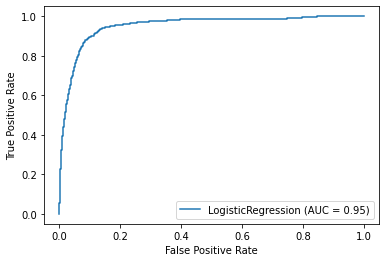

In [138]:
#### Plotting the roc curve for the model fit ####

plot_roc_curve(LR_model,X =X_train, y= Y_train)

In [139]:
Y_train.value_counts()

0    7254
1     869
Name: Revenue Grid, dtype: int64

In [140]:
### Getting confusion matrix, F-score on the train data #####

print(confusion_matrix(y_true = Y_train, y_pred = LR_model.predict(X_train))) ### confusion matrix for pred on train set

print ('The F1-SCORE on the train set prediction ',f1_score(y_true=Y_train,y_pred = LR_model.predict(X_train),sample_weight = Y_train))

[[6540  714]
 [  94  775]]
The F1-SCORE on the train set prediction  0.9428223844282239


0    1814
1     217
Name: Revenue Grid, dtype: int64
[[1622  192]
 [  25  192]]
The F1-SCORE on the test set prediction  0.9388753056234719


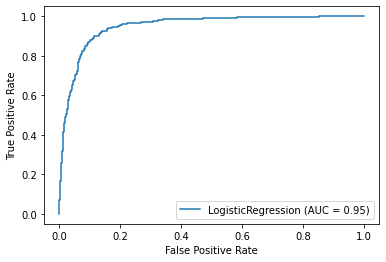

In [141]:
##### Lets evaluate the performace on the test set #####
print(Y_val.value_counts())

plot_roc_curve(LR_model,X =X_val, y= Y_val)

predicted_test = LR_model.predict(X_val)

print (confusion_matrix(y_true = Y_val, y_pred = predicted_test))

print ('The F1-SCORE on the test set prediction ',f1_score(y_true=Y_val,y_pred = predicted_test,sample_weight = Y_val))

In [142]:
with open('logistic_model.pickle','wb') as f:
  pickle.dump(LR_model,f)

In [143]:
with open('logistic_model.pickle','rb') as f:
  model = pickle.load(f)

In [ ]:
##### fitting a decision tree #####

##### We experiment ###
#### max_depth = 5, max_features = 8,   min_samples_split = 10 --> Training f1 score, val f1 score
#### max_depth = 7, max_features = 10,  min_samples_split = 8 --> Trining f1 score, val f1 score
#### max_depth = 9, max_features = 12,  min_samples_split = 6 --> Trining f1 score, val f1 score
#### max_depth = 20, max_features = 69, min_sample_split = 2 --> Training F1 score, val f1 score
#### max_depth = 15, max_features = 50, min_sample_split = 5 --> Training F1 score, val f1 score

clf = DecisionTreeClassifier(class_weight ='balanced',max_depth = 5, criterion = 'entropy',max_features=8,min_samples_split=10)

clf.fit(X_train,Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=5, max_features=8,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')

In [ ]:
##### Creating a decision tree classifier ####

clf=DecisionTreeClassifier()
#clf = LogisticRegression()  
#clf = SVC()

params={'class_weight':['balanced'], 
        'max_features' : [1,5],
        'max_depth' : [6,7,8,9,10],
        'criterion' :['gini','entropy'],
        'min_samples_split' : [2,5,10,20]}           ### parameter distribution 


In [ ]:
##### Fitting grid search cv to find the best combination of hyper parameters ####

grid_search = GridSearchCV(estimator = clf,param_grid = params,cv = 5,scoring = 'f1', return_train_score=True)

grid_search.fit(features_df,target_df)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'class_weight': ['balanced'],
                       

In [ ]:
list(grid_search.cv_results_.keys())

['mean_fit_time',
 'std_fit_time',
 'mean_score_time',
 'std_score_time',
 'param_class_weight',
 'param_criterion',
 'param_max_depth',
 'param_max_features',
 'param_min_samples_split',
 'params',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'mean_test_score',
 'std_test_score',
 'rank_test_score',
 'split0_train_score',
 'split1_train_score',
 'split2_train_score',
 'split3_train_score',
 'split4_train_score',
 'mean_train_score',
 'std_train_score']

In [ ]:
grid_search.cv_results_['params']
print(grid_search.cv_results_['mean_test_score'])
print(grid_search.cv_results_['mean_train_score'])

print(grid_search.cv_results_['params'][10])

[0.19475487 0.24473023 0.21190956 0.1669288  0.31305309 0.21962542
 0.36898273 0.29012254 0.25617661 0.23110192 0.42205414 0.33229939
 0.11934149 0.16031815 0.25534131 0.2787693  0.24130251 0.23456838
 0.33192438 0.34904643 0.23958848 0.25856985 0.35287184 0.36492149]
[0.2103397  0.24606002 0.21136605 0.17383824 0.32521225 0.23882485
 0.38092303 0.30969262 0.27231912 0.2491024  0.44897143 0.34096592
 0.13142434 0.16501146 0.25044151 0.28194486 0.25486461 0.25380261
 0.33368178 0.36634283 0.25317389 0.28797781 0.37558985 0.38525349]
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'max_features': 5, 'min_samples_split': 2}


In [ ]:
print(grid_search.best_estimator_) #### Automatically give you the best parameter combination

#print(grid_search.best_score_) #### best score

#print(grid_search.cv_results_) ### dictionary ('What are the parameter combinations', avg_train_f1_score, avg_val_f1_score)

#best_params = grid_search.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=5, max_features=5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


In [ ]:
### Manually split the data into 1 fold 80% 20%
### create a decision tree model with the best combination that was identified
### Predict on the train set using the built model.
### AUC,confusion matrix, f1score on the trainpredictions
### prediction on the validation set
### AUC, Confusion matrix,f1 score

In [ ]:
#### Fitting on the entire dataset ####

#clf = DecisionTreeClassifier(max_depth =5, max_features =5, criterion = 'gini')

clf = DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=5, max_features=50, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

clf.fit(X_train,Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=5, max_features=50, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

[[6812  442]
 [  68  801]]
The F1-SCORE on the train set prediction  0.9592814371257484


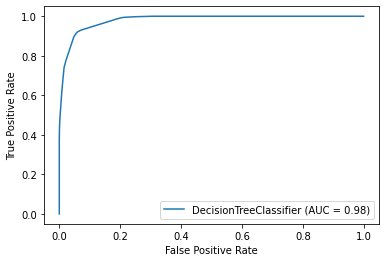

In [ ]:
### Evaluating on the train and the test set ####

predicted_train = clf.predict(X_train)

plot_roc_curve(clf,X =X_train, y= Y_train)

#print ('The score for the DT model ', roc_auc_score(Y_train,predicted_train))

print(confusion_matrix(y_true = Y_train, y_pred = predicted_train))

print ('The F1-SCORE on the train set prediction ',f1_score(y_true=Y_train,y_pred = predicted_train,sample_weight = Y_train))

[[1682  132]
 [  32  185]]
The F1-SCORE on the test set prediction  0.9203980099502488


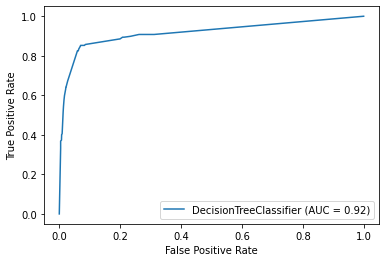

In [ ]:
plot_roc_curve(clf,X =X_val, y= Y_val)

predicted_test = clf.predict(X_val)

print (confusion_matrix(y_true = Y_val, y_pred = predicted_test))

print ('The F1-SCORE on the test set prediction ',f1_score(y_true=Y_val,y_pred = predicted_test,sample_weight = Y_val))

In [ ]:
### Calculating the feature importances ####

importances = clf.feature_importances_

columns = list(X_train.columns)

importances_dict = {columns[i]: importances[i] for i in range(len(columns))}

importances_dict = dict(sorted(importances_dict.items(), key=lambda importances_dict: importances_dict[1],reverse=True))

In [ ]:
data['age_band'].value_counts()

45-50      1359
36-40      1134
41-45      1112
31-35      1061
51-55      1052
55-60      1047
26-30       927
61-65       881
65-70       598
22-25       456
71+         410
18-21        63
Unknown      55
Name: age_band, dtype: int64

In [ ]:
importances_dict

{'Average A/C Balance': 0.009589225329617231,
 'Average Credit Card Transaction': 0.07287466065747035,
 'Balance Transfer': 0.0,
 'Home Loan': 0.005919866357424682,
 'Investment Tax Saving Bond': 0.15863513226147152,
 'Investment in Commudity': 0.20133786154180974,
 'Investment in Derivative': 0.031203133015147134,
 'Investment in Equity': 0.003064345329717135,
 'Investment in Mutual Fund': 0.0,
 'Life Insurance': 0.05939864315157473,
 'Medical Insurance': 0.006762384080429247,
 'Online Purchase Amount': 0.41621269868212873,
 'Personal Loan': 0.012690852754192905,
 'Portfolio Balance': 0.0,
 'Term Deposit': 0.0223111968390167,
 'age_band_18-21': 0.0,
 'age_band_22-25': 0.0,
 'age_band_26-30': 0.0,
 'age_band_31-35': 0.0,
 'age_band_36-40': 0.0,
 'age_band_41-45': 0.0,
 'age_band_45-50': 0.0,
 'age_band_51-55': 0.0,
 'age_band_55-60': 0.0,
 'age_band_61-65': 0.0,
 'age_band_65-70': 0.0,
 'age_band_71+': 0.0,
 'chidren_1': 0.0,
 'chidren_2': 0.0,
 'chidren_3': 0.0,
 'chidren_Zero': 0.0,


In [ ]:
X_train.columns

Index(['Average Credit Card Transaction', 'Balance Transfer', 'Term Deposit',
       'Life Insurance', 'Medical Insurance', 'Average A/C Balance',
       'Personal Loan', 'Investment in Mutual Fund',
       'Investment Tax Saving Bond', 'Home Loan', 'Online Purchase Amount',
       'Investment in Commudity', 'Investment in Equity',
       'Investment in Derivative', 'Portfolio Balance', 'chidren_1',
       'chidren_2', 'chidren_3', 'chidren_Zero', 'age_band_18-21',
       'age_band_22-25', 'age_band_26-30', 'age_band_31-35', 'age_band_36-40',
       'age_band_41-45', 'age_band_45-50', 'age_band_51-55', 'age_band_55-60',
       'age_band_61-65', 'age_band_65-70', 'age_band_71+', 'status_Partner',
       'status_Single/Never Married', 'status_Widowed', 'occupation_Housewife',
       'occupation_Manual Worker', 'occupation_Other',
       'occupation_Professional', 'occupation_Retired',
       'occupation_Secretarial/Admin', 'occupation_Student',
       'occupation_Unknown', 'occupation_pa

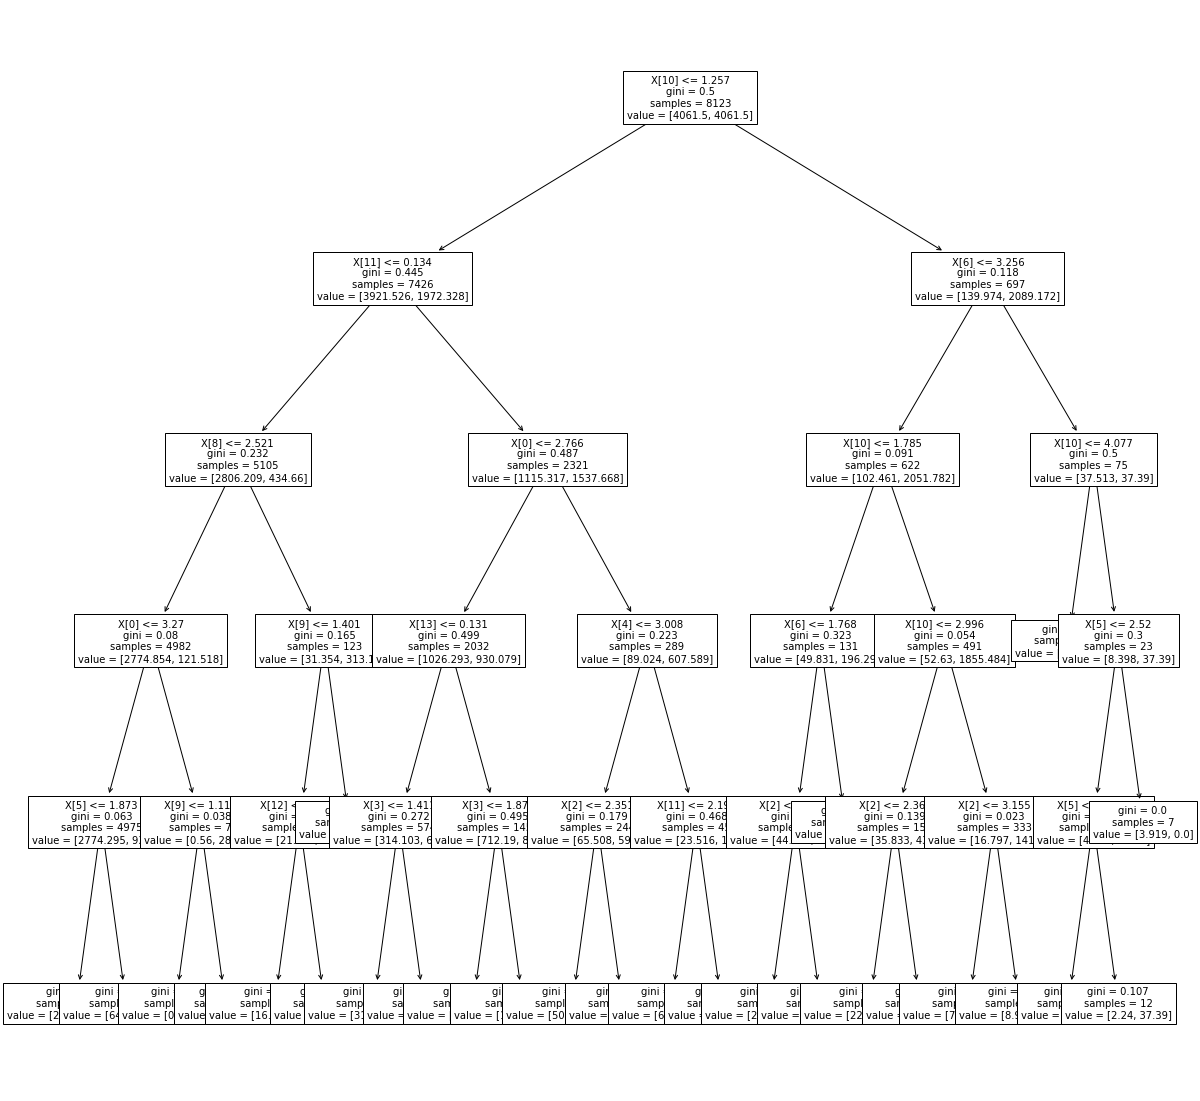

In [ ]:
from sklearn.tree import plot_tree
plot_rows =1
plot_cols = 1

fig, ax1 = plt.subplots(nrows = plot_rows,ncols=plot_cols,figsize = (20,20))

plot_tree(clf,ax=ax1,fontsize=10)
plt.show()

In [ ]:
#### Saving the model ###

with open('decision_tree_model.pickle','wb') as f:
    pickle.dump(clf,f)


In [ ]:
#### Fitting a decision tree classifier ######

clf = RandomForestClassifier() ### random forest function from  sklearn

params={'n_estimators':[50,70,100],
        'class_weight':['balanced'], 
        'criterion':['entropy','gini'],
        'max_depth':[8,9,10],
        'min_samples_split':[5,10,12,13,15],
        'max_samples':[0.7,0.8,0.9]}        #### parameter combinations

In [ ]:
##### Fitting grid search cv to find the best combination of hyper parameters ####

grid_search = GridSearchCV(estimator = clf,param_grid = params,cv = 5,scoring = 'f1',return_train_score=True)

grid_search.fit(features_df,target_df)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
grid_search.cv_results_ ### parameter comb,train_score, val_score

{'mean_fit_time': array([0.18732467, 0.26923275, 0.37789311, 0.18745551, 0.26516881,
        0.37385206, 0.19828801, 0.26272049, 0.37613697, 0.19112062,
        0.26036167, 0.37373462, 0.20054994, 0.2873827 , 0.40237045,
        0.2027185 , 0.28730636, 0.40516157, 0.20331893, 0.28457747,
        0.39703965, 0.19802947, 0.28121233, 0.39102378, 0.20696068,
        0.29536901, 0.40563016, 0.20672493, 0.29078994, 0.41548414,
        0.21008439, 0.2884707 , 0.42100301, 0.20734725, 0.292978  ,
        0.40376329, 0.23131161, 0.31832881, 0.45091281, 0.23227191,
        0.31205635, 0.44900918, 0.22590613, 0.31817608, 0.44753032,
        0.22607646, 0.31385336, 0.44770064, 0.24520631, 0.34987321,
        0.49330807, 0.24061623, 0.34589891, 0.48370495, 0.23595676,
        0.32828455, 0.48127565, 0.23596921, 0.34033499, 0.47796183,
        0.25998869, 0.36321402, 0.51450386, 0.2609468 , 0.36184101,
        0.51049027, 0.25637732, 0.35450678, 0.50593381, 0.25516453,
        0.35886965, 0.51093922,

In [ ]:
combinations = grid_search.cv_results_['params']
len(combinations)

288

In [ ]:
combinations[0]

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 5,
 'max_samples': 0.7,
 'min_samples_split': 5,
 'n_estimators': 50}

In [ ]:
print(best_estimator_) #### best combination

print(grid_search.best_score_) #### best score

best_params = grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
0.6366483844707207


In [ ]:
clf = best_params

clf.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

The score for the DT model  0.9330899693292506
[[6517  737]
 [  28  841]]
The F1-SCORE on the train set prediction  0.9836257309941521


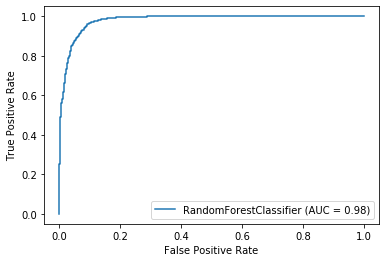

In [ ]:
### Evaluating on the train and the test set ####

predicted_train = clf.predict(X_train)

plot_roc_curve(clf,X =X_train, y= Y_train)

print ('The score for the DT model ', roc_auc_score(Y_train,predicted_train))

print(confusion_matrix(y_true = Y_train, y_pred = predicted_train))

print ('The F1-SCORE on the train set prediction ',f1_score(y_true=Y_train,y_pred = predicted_train,sample_weight = Y_train))

[[1635  179]
 [  18  199]]
The F1-SCORE on the test set prediction  0.9567307692307692


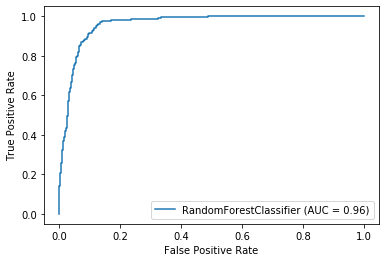

In [ ]:
plot_roc_curve(clf,X =X_test, y= Y_test)

predicted_test = clf.predict(X_test)

print (confusion_matrix(y_true = Y_test, y_pred = predicted_test))

print ('The F1-SCORE on the test set prediction ',f1_score(y_true=Y_test,y_pred = predicted_test,sample_weight = Y_test))

In [ ]:
### Calculating the feature importances ####

importances = clf.feature_importances_

columns = list(X_train.columns)

importances_dict = {columns[i]: importances[i] for i in range(len(columns))}

importances_dict = dict(sorted(importances_dict.items(), key=lambda importances_dict: importances_dict[1],reverse=True))

In [ ]:
importances_dict

{'Online Purchase Amount': 0.25058942520264027,
 'Investment in Equity': 0.12186209029195244,
 'Investment Tax Saving Bond': 0.0920667178803737,
 'Investment in Commudity': 0.08765194601648314,
 'Portfolio Balance': 0.08510295700920222,
 'Average Credit Card Transaction': 0.07587171781695444,
 'Life Insurance': 0.05685350515510326,
 'Investment in Derivative': 0.050924328929323935,
 'Personal Loan': 0.02947762486396119,
 'Investment in Mutual Fund': 0.024006526807807595,
 'Term Deposit': 0.022154518885781956,
 'Average A/C Balance': 0.021230367207415928,
 'Balance Transfer': 0.015652451118176213,
 'Medical Insurance': 0.014054781682469398,
 'Home Loan': 0.00964345147789945,
 'gender_Male': 0.0012955968059249366,
 'income_<27,500, >=25,000': 0.0011456888588684013,
 'income_>=35,000': 0.0010763505462227576,
 'occupation_Secretarial/Admin': 0.0010537860538890988,
 'region_South West': 0.0009961913428479141,
 'age_band_45-50': 0.0009910161810580346,
 'self_employed_partner_Yes': 0.00094376

In [ ]:
##### Saving the model into a pickle file #####
import pickle

with open('/Users/anil.goyal/Documents/random_forest_test_1.pickle','wb') as f:
    pickle.dump(clf,f)

In [ ]:
##### Loading the model from a pickle file #####

import pickle

with open('/Users/anil.goyal/Documents/random_forest_test_1.pickle','rb') as f:
    model = pickle.load(f)

FileNotFoundError: ignored